In [2]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest, uncertainty_subtraction as us, calculate as calc

from astropy.table import hstack
import numpy as np
import matplotlib.pyplot as plt

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

master_hvcs = hvcl.load_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 24])

bigger_results = ct.read_processed("../data_processed/results_raw_RM")
big_results_filtered = us.filter_significant(bigger_results)
big_results_filtered

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete


Name,Statistic,p_value,Statistic_x,Statistic_sgn,Statistic_diff,Significant,Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM,Average [inner],Average [outer],Average [diff],Avg Unc [inner],Avg Unc [outer],Avg Unc [diff],KS unc,Sigma unc
str15,float64,float64,float64,int32,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-23.129523665567874,-1,16.86046632442212,True,7.315711919790323,21.44495684338161,20.158534994417067,-7.5559356070774975,-17.792868626509186,-9.010901261901203,-16.691518833687702,7.680617571786499,0.1544710566244403,0.06975604516150032,0.16949104156634448,10.197803752505306,2.2518324731757904
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-6.963302929232215,-1,12.50616654023725,True,7.247502115395694,22.736827410419288,21.5508012328667,-3.6485845077294528,-8.591759934790694,-0.6960604023293531,-11.978620978240315,11.282560575910962,0.4934626372172539,0.03289730408607167,0.4945579914889038,10.456531084285634,2.6668570115023877
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-9.607423653882606,-1,17.56975352329457,True,7.411948080584831,26.053745901546854,24.977203629571594,-2.3590579203581576,-5.555156878248415,13.132260146632955,0.8190631739611469,12.313196972671808,0.20749211378340493,0.06703715396383249,0.2180526479863889,11.300489917991937,1.3278611851317375
G133.5-75.6-294,0.46130268199233715,4.570648166268751e-08,-5.571498219868521,-1,9.893967245596944,True,3.1053847739136637,3.5608394245679476,1.7424588412650028,-6.847658270169869,-16.125002956117964,-2.168078601732155,-6.370877536021758,4.202798934289603,0.20314919434020826,0.04004602282589842,0.2070586368767265,4.6636656614819545,1.022384857086496
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-9.242870775459728,-1,11.928300395711442,True,8.594854462293316,21.06597665131827,19.23288457423595,6.542074154087057,15.405407354123094,-11.764841199688588,-17.481018590675696,5.716177390987108,0.561224497952308,0.14982108400037036,0.5808780373820878,11.93135412518456,1.6066118106893406
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,5.330447266073939,-1,13.188305123931798,True,10.157119529631,25.64311095033743,23.545744033096597,-28.767857863402234,-67.7431283493408,12.994898045135406,2.6170295774063628,10.377868467729042,0.46755894063459996,0.17864583221397004,0.5005254202683129,14.305615588516298,20.933540713370725
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,2.861884589161079,1,-6.697674970398481,True,5.927300141806982,15.73809348278103,14.579255793821908,0.35850194470109464,0.8442075655647145,1.6847642877788824,8.566817538848705,-6.882053251069822,0.627066596774432,0.04772657752967211,0.628880229449904,8.228261532281218,4.1676559238474775
G267.1-38.4+263,0.3428488020518381,2.318648482161409e-11,29.111033886656486,-1,21.553476329098928,True,8.13486037878398,31.995920177575528,30.944514128153237,8.787618562445854,20.693260338933552,7.87911832667194,-0.09597795759895843,7.975096284270899,0.5391312832435591,0.07778003997912636,0.544713020948647,11.432221120754418,3.8359261001909055
G271.6-48.4+297,0.12493061782161308,5.0905622111774864e-05,3.6754826316026303,-1,3.4252323813523766,True,6.313050583159695,17.46551131755536,16.284639324164395,0.7298893876279617,1.7187581606416888,6.2498163873875034,5.805870004194806,0.4439463831926975,0.07038771856457283,0.05003114749376412,0.0863570879793216,9.09989926333979,1.5176725396155768


In [3]:
from astropy.table import Table

def post_process_magnetic_fields(master_hvcs, data):
    name_list = []
    sign_list = []
    uner_list = []

    ksl_list = []
    uns_list = []
    wgm_list = []

    ksl_unc_list = []
    uns_unc_list = []
    wgm_unc_list = []

    for i in range(len(master_hvcs)):
        name_list.append(master_hvcs[i]["HVC"]["Name"])
        sign_list.append(data[i]["Significant"])
        uner_list.append(data[i]["Sigma [diff]"])

        val = calc.B_virt(master_hvcs[i]["HVC"]["NH"], master_hvcs[i]["HVC"]["e_NH"], data[i]["Statistic_diff"], data[i]["KS unc"])[0]
        ksl_list.append(val.n)
        ksl_unc_list.append(val.s)

        val = calc.B_virt(master_hvcs[i]["HVC"]["NH"], master_hvcs[i]["HVC"]["e_NH"], data[i]["Sigma [diff]"], data[i]["Sigma unc"])[0]
        uns_list.append(val.n)
        uns_unc_list.append(val.s)

        val = calc.B_virt(master_hvcs[i]["HVC"]["NH"], master_hvcs[i]["HVC"]["e_NH"], data[i]["Average [diff]"], data[i]["Avg Unc [diff]"])[0]
        wgm_list.append(val.n)
        wgm_unc_list.append(val.s)
    
    t = Table()
    t.add_columns([name_list, sign_list, uner_list, ksl_list, ksl_unc_list, uns_list, uns_unc_list, wgm_list, wgm_unc_list], names=["Name", "Significant", "Sigma [diff]", "KS-EDF", "KS-EDF Unc", "Var. Sub.", "Var. Sub. Unc", "Wgt. Mean", "Wgt. Mean Unc"])
    return t

finals = post_process_magnetic_fields(master_hvcs, bigger_results)
filtered = us.filter_significant(finals)


In [4]:
results = ct.write_processed(filtered, "../data_processed/results_post_RM")

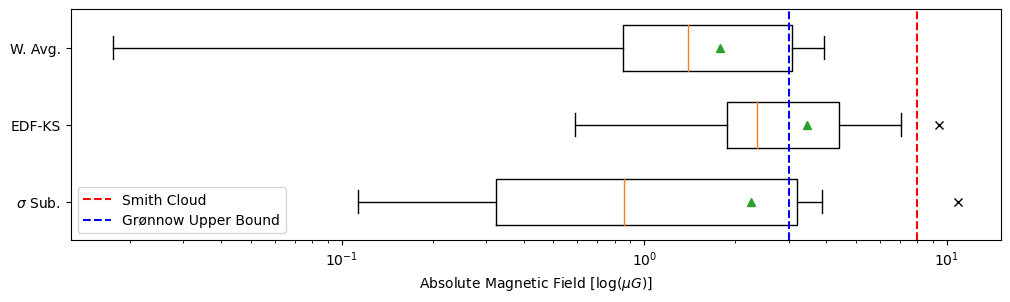

In [5]:
dic = {r"$\sigma$ Sub.": abs(filtered["Var. Sub."]), "EDF-KS": abs(filtered["KS-EDF"]), "W. Avg.": abs(filtered["Wgt. Mean"])}
plt.figure(figsize=(12,3))
plt.boxplot(dic.values(), labels=dic.keys(), vert=False, showmeans=True, widths=0.6, sym="x")
plt.axvline(8, c='r', linestyle='--', label=r"Smith Cloud")
plt.axvline(3, c='b', linestyle='--', label=r"Grønnow Upper Bound")
plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.xscale('log')
#plt.xlim(0.1, 15)
plt.legend()
plt.show()

In [6]:
from scipy.stats import linregress

results_stack = us.filter_significant(hstack([finals, collated_data['HVCs']]))

Var. Sub. slope: -12.572703226550608
KS-EDF slope:    -26.856579544439352
Wgt. Avg. slope: -3.8528375397646086
Var. Sub. x-int: 1.6735447035564783
KS-EDF x-int:    1.5285419214826035
Wgt. Avg. x-int: 4.336392407460455
Var. Sub. R^2:   0.059632232139626914
KS-EDF R^2:      0.05764859225859303
Wgt. Avg. R^2:   0.007095225964694864


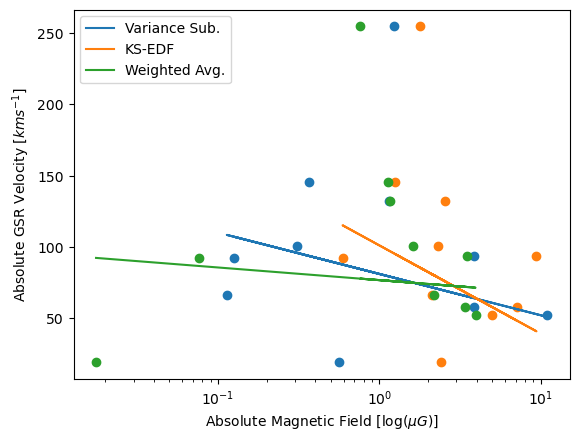

In [7]:
plt.scatter(abs(results_stack["Var. Sub."]), abs(results_stack['VGSR']))
plt.scatter(abs(results_stack["KS-EDF"]), abs(results_stack['VGSR']))
plt.scatter(abs(results_stack["Wgt. Mean"]), abs(results_stack['VGSR']))

plt.xscale('log')
#plt.xlim(0.1, 15)

pf10, pf11, r_value1, p_value1, std_err1 = linregress(np.log(abs(results_stack["Var. Sub."])), abs(results_stack['VGSR']))
pf20, pf21, r_value2, p_value2, std_err2 = linregress(np.log(abs(results_stack["KS-EDF"])), abs(results_stack['VGSR']))
pf30, pf31, r_value3, p_value3, std_err3 = linregress(np.log(abs(results_stack["Wgt. Mean"])), abs(results_stack['VGSR']))

plt.plot(abs(results_stack["Var. Sub."]), pf10 * np.log(abs(results_stack["Var. Sub."])) + pf11, label="Variance Sub.")
plt.plot(abs(results_stack["KS-EDF"]), pf20 * np.log(abs(results_stack["KS-EDF"])) + pf21, label="KS-EDF")
plt.plot(abs(results_stack["Wgt. Mean"]), pf30 * np.log(abs(results_stack["Wgt. Mean"])) + pf31, label="Weighted Avg.")

plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.ylabel(r"Absolute GSR Velocity [$km s^{-1}$]")
plt.legend()

print(r"Var. Sub. slope: "+str(pf10))
print(r"KS-EDF slope:    "+str(pf20))
print(r"Wgt. Avg. slope: "+str(pf30))

#print(r"Var. Sub. y-int: "+str(pf11))
#print(r"KS-EDF y-int:    "+str(pf21))

print(r"Var. Sub. x-int: "+str((60-pf11)/pf10))
print(r"KS-EDF x-int:    "+str((60-pf21)/pf20))
print(r"Wgt. Avg. x-int: "+str((60-pf31)/pf30))

print(r"Var. Sub. R^2:   "+str(r_value1**2))
print(r"KS-EDF R^2:      "+str(r_value2**2))
print(r"Wgt. Avg. R^2:   "+str(r_value3**2))

plt.show()

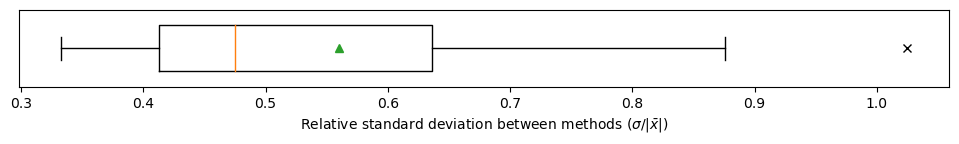

In [8]:
plt.figure(figsize=(12,1))

lists = [abs(big_results_filtered["Sigma [diff]"]), abs(big_results_filtered["Statistic_diff"]), abs(big_results_filtered["Average [diff]"])]

std = np.std(lists, axis=0)/np.mean(lists, axis=0)

plt.boxplot(std, vert=False, showmeans=True,widths=0.6, sym="x")
plt.yticks([])
#plt.axvline(8, c='r', linestyle='--', label=r"Smith Cloud")
plt.xlabel(r"Relative standard deviation between methods ($\sigma/|\bar{x}|$)")
#plt.xscale('log')
#plt.xlim(0.1, 15)
#plt.legend()
plt.show()